
======================================================================
Common pitfalls in the interpretation of coefficients of linear models
======================================================================

In linear models, the target value is modeled as a linear combination of the
features (see the :ref:`linear_model` User Guide section for a description of a
set of linear models available in scikit-learn). Coefficients in multiple linear
models represent the relationship between the given feature, :math:`X_i` and the
target, :math:`y`, assuming that all the other features remain constant
(`conditional dependence
<https://en.wikipedia.org/wiki/Conditional_dependence>`_). This is different
from plotting :math:`X_i` versus :math:`y` and fitting a linear relationship: in
that case all possible values of the other features are taken into account in
the estimation (marginal dependence).

This example will provide some hints in interpreting coefficient in linear
models, pointing at problems that arise when either the linear model is not
appropriate to describe the dataset, or when features are correlated.

.. note::

    Keep in mind that the features :math:`X` and the outcome :math:`y` are in
    general the result of a data generating process that is unknown to us.
    Machine learning models are trained to approximate the unobserved
    mathematical function that links :math:`X` to :math:`y` from sample data. As
    a result, any interpretation made about a model may not necessarily
    generalize to the true data generating process. This is especially true when
    the model is of bad quality or when the sample data is not representative of
    the population.

We will use data from the `"Current Population Survey"
<https://www.openml.org/d/534>`_ from 1985 to predict wage as a function of
various features such as experience, age, or education.

Authors: The scikit-learn developers
SPDX-License-Identifier: BSD-3-Clause

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

The dataset: wages
------------------

We fetch the data from `OpenML <http://openml.org/>`_.
Note that setting the parameter `as_frame` to True will retrieve the data
as a pandas dataframe.

In [2]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)

Then, we identify features `X` and targets `y`: the column WAGE is our
target variable (i.e., the variable which we want to predict).

In [8]:
X = survey.data[survey.feature_names]
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


Note that the dataset contains categorical and numerical variables.
We will need to take this into account when preprocessing the dataset
thereafter.

In [9]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married


Our target for prediction: the wage.
Wages are described as floating-point number in dollars per hour.

In [5]:
y = survey.target.values.ravel()
survey.target.head()

,WAGE
0,5.10
1,4.95
2,6.67
3,4.00
4,7.50


We split the sample into a train and a test dataset.
Only the train dataset will be used in the following exploratory analysis.
This is a way to emulate a real situation where predictions are performed on
an unknown target, and we don't want our analysis and decisions to be biased
by our knowledge of the test data.

### 📝 TODO make the train test split

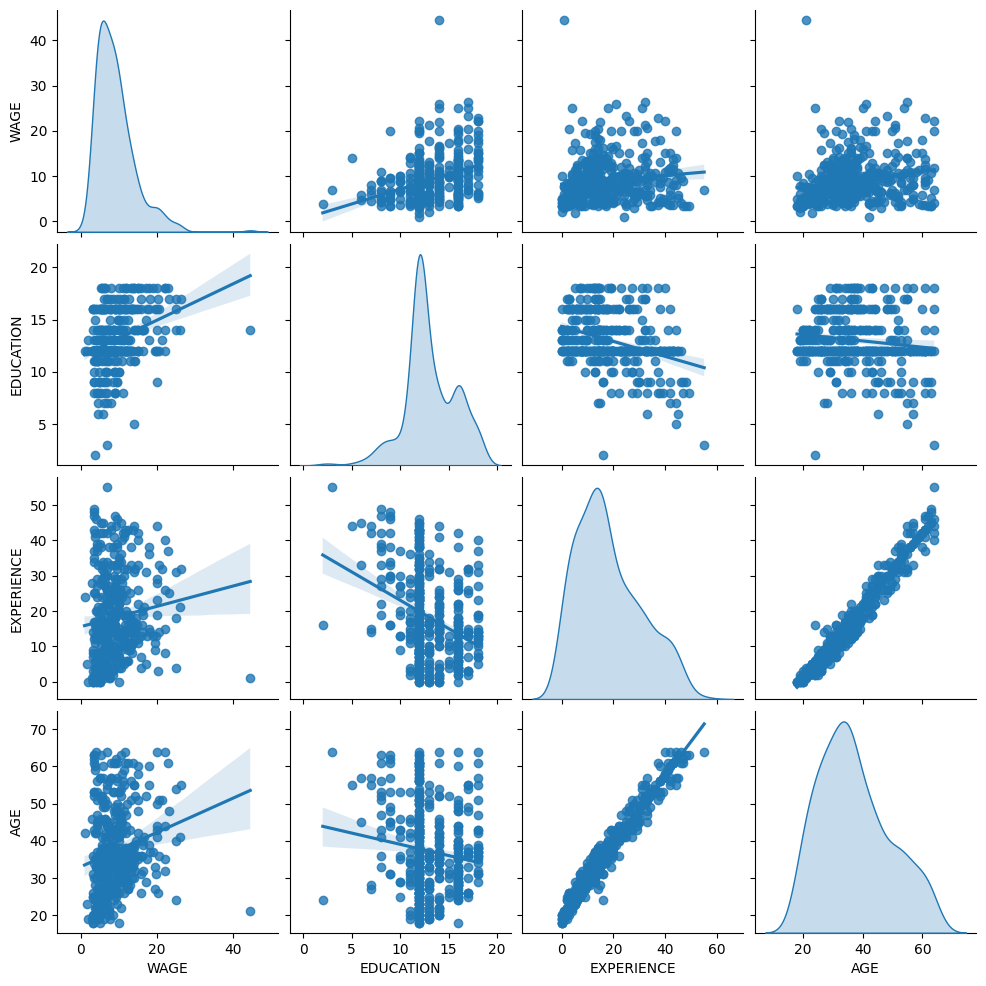

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

First, let's get some insights by looking at the variable distributions and
at the pairwise relationships between them. Only numerical
variables will be used. In the following plot, each dot represents a sample.

.. _marginal_dependencies:

train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

Looking closely at the WAGE distribution reveals that it has a
long tail. For this reason, we should take its logarithm
to turn it approximately into a normal distribution (linear models such
as ridge or lasso work best for a normal distribution of error).

The WAGE is increasing when EDUCATION is increasing.
Note that the dependence between WAGE and EDUCATION
represented here is a marginal dependence, i.e., it describes the behavior
of a specific variable without keeping the others fixed.

Also, the EXPERIENCE and AGE are strongly linearly correlated.

.. _the-pipeline:

The machine-learning pipeline
-----------------------------

To design our machine-learning pipeline, we first manually
check the type of data that we are dealing with:

In [10]:
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   AGE         534 non-null    int64   
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), int64(3)
memory usage: 17.3 KB


As seen previously, the dataset contains columns with different data types
and we need to apply a specific preprocessing for each data types.
In particular categorical variables cannot be included in linear model if not
coded as integers first. In addition, to avoid categorical features to be
treated as ordered values, we need to one-hot-encode them.
Our pre-processor will

- one-hot encode (i.e., generate a column by category) the categorical
  columns, only for non-binary categorical variables;
- as a first approach (we will see after how the normalisation of numerical
  values will affect our discussion), keep numerical values as they are.

### 📝 TODO : create a preprocessor that handle the categorical columns with a OneHotEncoder and does nothing with the numerical ones

In [17]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
# CODE HERE

To describe the dataset as a linear model we use a ridge regressor
with a very small regularization and to model the logarithm of the WAGE.
### 📝 TODO: make a pipeline with the preprocessor, and a ridge regressor encapusled in a TransformedTargetRegressor with a log10 transformation.

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
# CODE HERE

Processing the dataset
----------------------

First, we fit the model.

In [ ]:
# CODE HERE
# ### 📝 TODO: fit the model

Then we check the performance of the computed model plotting its predictions
on the test set and computing,
for example, the median absolute error of the model.

In [ ]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

In [ ]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

The model learnt is far from being a good model making accurate predictions:
this is obvious when looking at the plot above, where good predictions
should lie on the black dashed line.

In the following section, we will interpret the coefficients of the model.
While we do so, we should keep in mind that any conclusion we draw is
about the model that we build, rather than about the true (real-world)
generative process of the data.

Interpreting coefficients: scale matters
----------------------------------------

First of all, we can take a look to the values of the coefficients of the
regressor we have fitted.
### 📝 TODO: use the `.get_feature_names_out()` to inspect the coefs

In [ ]:
# CODE HERE
print(coefs)

The AGE coefficient is expressed in "dollars/hour per living years" while the
EDUCATION one is expressed in "dollars/hour per years of education". This
representation of the coefficients has the benefit of making clear the
practical predictions of the model: an increase of :math:`1` year in AGE
means a decrease of :math:`0.030867` dollars/hour, while an increase of
:math:`1` year in EDUCATION means an increase of :math:`0.054699`
dollars/hour. On the other hand, categorical variables (as UNION or SEX) are
adimensional numbers taking either the value 0 or 1. Their coefficients
are expressed in dollars/hour. Then, we cannot compare the magnitude of
different coefficients since the features have different natural scales, and
hence value ranges, because of their different unit of measure. This is more
visible if we plot the coefficients.

In [ ]:
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

Indeed, from the plot above the most important factor in determining WAGE
appears to be the
variable UNION, even if our intuition might tell us that variables
like EXPERIENCE should have more impact.

Looking at the coefficient plot to gauge feature importance can be
misleading as some of them vary on a small scale, while others, like AGE,
varies a lot more, several decades.

This is visible if we compare the standard deviations of different
features.
%%%
X_train_preprocessed = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names
)
## 📝 TODO: plot the standard deviations of the features
X_train_preprocessed.std(axis=0).plot.barh(figsize=(9, 7))
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values")
plt.subplots_adjust(left=0.3)

Multiplying the coefficients by the standard deviation of the related
feature would reduce all the coefficients to the same unit of measure.
As we will see :ref:`after<scaling_num>` this is equivalent to normalize
numerical variables to their standard deviation,
as :math:`y = \sum{coef_i \times X_i} =
\sum{(coef_i \times std_i) \times (X_i / std_i)}`.

In that way, we emphasize that the
greater the variance of a feature, the larger the weight of the corresponding
coefficient on the output, all else being equal.

In [ ]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_ * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Now that the coefficients have been scaled, we can safely compare them.

.. warning::

  Why does the plot above suggest that an increase in age leads to a
  decrease in wage? Why the :ref:`initial pairplot
  <marginal_dependencies>` is telling the opposite?

The plot above tells us about dependencies between a specific feature and
the target when all other features remain constant, i.e., **conditional
dependencies**. An increase of the AGE will induce a decrease
of the WAGE when all other features remain constant. On the contrary, an
increase of the EXPERIENCE will induce an increase of the WAGE when all
other features remain constant.
Also, AGE, EXPERIENCE and EDUCATION are the three variables that most
influence the model.

Interpreting coefficients: being cautious about causality
---------------------------------------------------------

Linear models are a great tool for measuring statistical association, but we
should be cautious when making statements about causality, after all
correlation doesn't always imply causation. This is particularly difficult in
the social sciences because the variables we observe only function as proxies
for the underlying causal process.

In our particular case we can think of the EDUCATION of an individual as a
proxy for their professional aptitude, the real variable we're interested in
but can't observe. We'd certainly like to think that staying in school for
longer would increase technical competency, but it's also quite possible that
causality goes the other way too. That is, those who are technically
competent tend to stay in school for longer.

An employer is unlikely to care which case it is (or if it's a mix of both),
as long as they remain convinced that a person with more EDUCATION is better
suited for the job, they will be happy to pay out a higher WAGE.

This confounding of effects becomes problematic when thinking about some
form of intervention e.g. government subsidies of university degrees or
promotional material encouraging individuals to take up higher education.
The usefulness of these measures could end up being overstated, especially if
the degree of confounding is strong. Our model predicts a :math:`0.054699`
increase in hourly wage for each year of education. The actual causal effect
might be lower because of this confounding.

Checking the variability of the coefficients
--------------------------------------------

We can check the coefficient variability through cross-validation:
it is a form of data perturbation (related to
`resampling <https://en.wikipedia.org/wiki/Resampling_(statistics)>`_).

If coefficients vary significantly when changing the input dataset
their robustness is not guaranteed, and they should probably be interpreted
with caution.

In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)

### 📝 TODO: use the cross_validate function to evaluate the coefficients on repeated splits. Use the splitting strategy `cv` defined above.

In [ ]:
# Assembling the coefficients
coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names,
)

In [ ]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

The problem of correlated variables
-----------------------------------

The AGE and EXPERIENCE coefficients are affected by strong variability which
might be due to the collinearity between the 2 features: as AGE and
EXPERIENCE vary together in the data, their effect is difficult to tease
apart.

To verify this interpretation we plot the variability of the AGE and
EXPERIENCE coefficient.
### 📝 TODO: use the plt.scatter for this.
.. _covariation:

In [ ]:
# CODE HERE

Two regions are populated: when the EXPERIENCE coefficient is
positive the AGE one is negative and vice-versa.

To go further we remove one of the 2 features and check what is the impact
on the model stability.
### 📝 TODO: drop the AGE column and run the same repeated split analysis on the dataset without this column.

In [ ]:
# CODE HERE
cv_model =

coefs =

In [ ]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.title("Coefficient importance and its variability")
plt.xlabel("Coefficient importance")
plt.suptitle("Ridge model, small regularization, AGE dropped")
plt.subplots_adjust(left=0.3)

The estimation of the EXPERIENCE coefficient now shows a much reduced
variability. EXPERIENCE remains important for all models trained during
cross-validation.

.. _scaling_num:

Preprocessing numerical variables
---------------------------------

As said above (see ":ref:`the-pipeline`"), we could also choose to scale
numerical values before training the model.
This can be useful when we apply a similar amount of regularization to all of them
in the ridge.
The preprocessor is redefined in order to subtract the mean and scale
variables to unit variance.
from sklearn.preprocessing import StandardScaler
### 📝 TODO: redifine the preprocessor to scale the numerical columns

In [ ]:
# CODE HERE
preprocessor =

In [ ]:
# The model will stay unchanged.

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)
model.fit(X_train, y_train)

Again, we check the performance of the computed
model using, for example, the median absolute error of the model and the R
squared coefficient.

In [ ]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

For the coefficient analysis, scaling is not needed this time because it
was performed during the preprocessing step.
### 📝 TODO: plot the new model coefficients

In [ ]:
coefs =

We now inspect the coefficients across several cross-validation folds. As in
the above example, we do not need to scale the coefficients by the std. dev.
of the feature values since this scaling was already
done in the preprocessing step of the pipeline.

In [ ]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

In [ ]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

The result is quite similar to the non-normalized case.

Linear models with regularization
---------------------------------

In machine-learning practice, ridge regression is more often used with
non-negligible regularization.

Above, we limited this regularization to a very little amount. Regularization
improves the conditioning of the problem and reduces the variance of the
estimates. :class:`~sklearn.linear_model.RidgeCV` applies cross validation
in order to determine which value of the regularization parameter (`alpha`)
is best suited for prediction.

In [ ]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)
model.fit(X_train, y_train)

In [ ]:
# First we check which value of :math:`\alpha` has been selected.

model[-1].regressor_.alpha_

Then we check the quality of the predictions.
### 📝 TODO: check the performances of the new regularized model.

In [ ]:
mae_train =
mae_test =
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

The ability to reproduce the data of the regularized model is similar to
the one of the non-regularized model.
### 📝 TODO: plot the new regularized model coefficients

In [ ]:
# CODE HERE
coefs =

The coefficients are significantly different.
AGE and EXPERIENCE coefficients are both positive but they now have less
influence on the prediction.

The regularization reduces the influence of correlated
variables on the model because the weight is shared between the two
predictive variables, so neither alone would have strong weights.

On the other hand, the weights obtained with regularization are more
stable (see the :ref:`ridge_regression` User Guide section). This
increased stability is visible from the plot, obtained from data
perturbations, in a cross-validation. This plot can be compared with
the :ref:`previous one<covariation>`.

cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

In [ ]:
plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

Linear models with sparse coefficients
--------------------------------------

Another possibility to take into account correlated variables in the dataset,
is to estimate sparse coefficients. In some way we already did it manually
when we dropped the AGE column in a previous ridge estimation.

Lasso models (see the :ref:`lasso` User Guide section) estimates sparse
coefficients. :class:`~sklearn.linear_model.LassoCV` applies cross
validation in order to determine which value of the regularization parameter
(`alpha`) is best suited for the model estimation.
### 📝 TODO: do the same analysis with LassoCV (L1 regularization)

In [ ]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation
model =

In [ ]:
# First we verify which value of :math:`\alpha` has been selected.

model[-1].regressor_.alpha_

Then we check the quality of the predictions.

In [ ]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(6, 6))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Lasso model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

For our dataset, again the model is not very predictive.

In [ ]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Lasso model, optimum regularization, normalized variables")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

A Lasso model identifies the correlation between
AGE and EXPERIENCE and suppresses one of them for the sake of the prediction.

It is important to keep in mind that the coefficients that have been
dropped may still be related to the outcome by themselves: the model
chose to suppress them because they bring little or no additional
information on top of the other features. Additionally, this selection
is unstable for correlated features, and should be interpreted with
caution.

Indeed, we can check the variability of the coefficients across folds.

In [ ]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

In [ ]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

We observe that the AGE and EXPERIENCE coefficients are varying a lot
depending of the fold.

Wrong causal interpretation
---------------------------

Policy makers might want to know the effect of education on wage to assess
whether or not a certain policy designed to entice people to pursue more
education would make economic sense. While Machine Learning models are great
for measuring statistical associations, they are generally unable to infer
causal effects.

It might be tempting to look at the coefficient of education on wage from our
last model (or any model for that matter) and conclude that it captures the
true effect of a change in the standardized education variable on wages.

Unfortunately there are likely unobserved confounding variables that either
inflate or deflate that coefficient. A confounding variable is a variable that
causes both EDUCATION and WAGE. One example of such variable is ability.
Presumably, more able people are more likely to pursue education while at the
same time being more likely to earn a higher hourly wage at any level of
education. In this case, ability induces a positive `Omitted Variable Bias
<https://en.wikipedia.org/wiki/Omitted-variable_bias>`_ (OVB) on the EDUCATION
coefficient, thereby exaggerating the effect of education on wages.

See the :ref:`sphx_glr_auto_examples_inspection_plot_causal_interpretation.py`
for a simulated case of ability OVB.

Lessons learned
---------------

* Coefficients must be scaled to the same unit of measure to retrieve
  feature importance. Scaling them with the standard-deviation of the
  feature is a useful proxy.
* Interpreting causality is difficult when there are confounding effects. If
  the relationship between two variables is also affected by something
  unobserved, we should be careful when making conclusions about causality.
* Coefficients in multivariate linear models represent the dependency
  between a given feature and the target, **conditional** on the other
  features.
* Correlated features induce instabilities in the coefficients of linear
  models and their effects cannot be well teased apart.
* Different linear models respond differently to feature correlation and
  coefficients could significantly vary from one another.
* Inspecting coefficients across the folds of a cross-validation loop
  gives an idea of their stability.
* Coefficients are unlikely to have any causal meaning. They tend
  to be biased by unobserved confounders.
* Inspection tools may not necessarily provide insights on the true
  data generating process.